In [1]:
#My attempt at multi SMP
#Starting work at pedros code

import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
from matplotlib import pyplot as plt
from roman_imsim.utils import roman_utils
import astropy.table as tb
import warnings 
from astropy.utils.exceptions import AstropyWarning
from erfa import ErfaWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.filterwarnings("ignore", category=ErfaWarning)
import scipy.sparse as sp 
#from pixmappy import Gnomonic
from scipy.linalg import block_diag, lstsq
from numpy.linalg import LinAlgError
from astropy.nddata import Cutout2D

from SMPfuncs import *
import time

'''
Cole Meldorf 2024
Heavily Adapted from code by Pedro Bernardinelli
   ___                         _____  __ 
  / _ \___  __ _  ___ ____    / __/ |/ /
 / , _/ _ \/  ' \/ _ `/ _ \  _\ \/    /
/_/|_|\___/_/_/_/\_,_/_//_/ /___/_/|_/ 
'''

print('Imported all modules...')



Updated version of SMP
Imported all modules...


In [2]:
def plop(small,big,x,y):
    '''
    Plop a small array into a big array at a certain location
    '''
    assert small.shape[0] % 2 == 1, 'Small array must be odd'
    assert small.shape[1] % 2 == 1, 'Small array must be odd'
    xsize = small.shape[1]//2
    ysize = small.shape[0]//2
    l = x - xsize
    r = x + xsize
    d = y - ysize
    u = y + ysize
    if l < 0:
        small = small[:,abs(l):]
        l = 0
    if r >= big.shape[1]:
        cap = big.shape[1]- r - 1
        small = small[:, :cap]
        r = big.shape[1]
    if d < 0:
        small = small[abs(d):,:]
        d = 0
    if u >= big.shape[0]:
        cap = big.shape[0] - u - 1
        small = small[:cap,:]
        u = big.shape[0]


    big[d:u+1,l:r+1] = small
    return big


def construct_psf_background(ra, dec, pointing, scanum, wcs, x_loc, y_loc, stampsize, flatten = True, color=0.61):
    #removed center_Ra and center_Dec

    '''
    Constructs the background model using PIFF's PSFs around a certain image (x,y) location and a given array of RA and DECs.
    The pixel coordinates are found using pixmappy's WCSs 
    stampsize determines how large the image will be (eg stampsize = 30 means a 30x30 image). 
    flatten decides if the image should be flattened (preferred) or not
    '''
    print('Constructing psf background locally with precise version...')

    config_file = './temp_tds.yaml'
    util_ref = roman_utils(config_file=config_file, visit = pointing, sca=scanum)


    x, y = wcs.world_to_pixel(SkyCoord(ra = np.array(ra)*u.degree, dec = np.array(dec)*u.degree))
    #x += 0.5
    #y += 0.5


    psfs = np.zeros((stampsize * stampsize,np.size(x)))

    k = 0

    for a,ij in enumerate(zip(x.flatten(),y.flatten())):
        i,j = ij
        result = getPSF_Image(util_ref, stampsize, x=x_loc, y=y_loc,  x_center = i, y_center=j, include_photonOps = False).array
        psfs[:,k] = result.flatten()
        k += 1

    return psfs



def construct_psf_background_plop(ra, dec, pointing, scanum, wcs, x_loc, y_loc, stampsize, flatten = True, color=0.61):
#removed center_Ra and center_Dec


    print('Constructing psf background locally...')

    osample = 9


    x, y = wcs.world_to_pixel(SkyCoord(ra = np.array(ra)*u.degree, dec = np.array(dec)*u.degree))
    x += 0.5
    y += 0.5
#Astropy defines pixel coordinates as the center of the pixel, so we add 0.5.


    psfs = np.zeros((stampsize * stampsize,np.size(x)))
    print('while cwork is down')
    config_file = './temp_tds.yaml'
    #config_file = '/hpc/home/cfm37/my_tds.yaml' 
    print(pointing, scanum)
    util_ref = roman_utils(config_file=config_file, visit = pointing, sca=scanum)

    cutout = util_ref.getPSF_Image(stampsize, x=x_loc, y=y_loc, oversampling_factor = osample).array 

    k = 0

    for a,ij in enumerate(zip(x.flatten(),y.flatten())):
        result = np.zeros((osample*stampsize,osample*stampsize))

        i,j = ij
        osamp_x = np.rint(osample*x.flatten()[a]).astype('int')
        osamp_y = np.rint(osample*y.flatten()[a]).astype('int')
        plop(cutout, result,osamp_x, osamp_y)
        down = downsample(result,osample)
        psfs[:,k] = down.flatten()
        k += 1

    return psfs


def insert(ra,dec,fullimage,flux, stampsize):
    snx, sny = fullimage[1].wcs.world_to_pixel(SkyCoord(ra =ra*u.degree, dec =dec*u.degree))
    snx += 0.5
    sny += 0.5
    x_cen, y_cen = self.findPixelCoords(i['Pointing'], int(i['SCA']), return_wcs=False, color = self.color)
    x_center, y_center = self.findPixelCoords(i['Pointing'], int(i['SCA']), return_wcs=False, color = self.color, cutout = True)





In [3]:
#%matplotlib widget

def open_parq(ID, path = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint'):
    df = pd.read_parquet(path+'/snana_'+str(ID)+'.parquet', engine='fastparquet')
    return df


def find_parq(ID, path = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint/'):
    #list files at a path
    import os

    files = os.listdir(path)
    files = [f for f in files if 'snana' in f]
    files = [f for f in files if '.parquet' in f]
    for f in files:
        pqfile = int(f.split('_')[1].split('.')[0])
        df = open_parq(pqfile, path)
        if ID in df.id.values:
            #print('Found ID in', pqfile)
            return pqfile


def radec2point(RA, DEC, filt, start = None, end = None, path = '/cwork/mat90/RomanDESC_sims_2024'):
    #This function takes in RA and DEC and returns the pointing and SCA with
    #center closest to desired RA/DEC
    f = fits.open(path+'/RomanTDS/Roman_TDS_obseq_11_6_23_radec.fits')[1]
    f = f.data

    g = fits.open(path+'/RomanTDS/Roman_TDS_obseq_11_6_23.fits')[1]
    g = g.data
    alldates = g['date']

    allRA = f['RA']
    allDEC = f['DEC']

    dist = np.sqrt((allRA - RA)**2 + (allDEC - DEC)**2)
    '''
    if start is not None:
        dist[np.where(alldates < start)] = np.inf
        dist[np.where(alldates > end)] = np.inf
    '''


    dist[np.where(f['filter'] != filt)] = np.inf #Ensuring we only get the filter we want




    reshaped_array = dist.flatten()
    # Find the indices of the minimum values along the flattened slices
    min_indices = np.argmin(reshaped_array, axis=0)
    # Convert the flat indices back to 2D coordinates
    rows, cols = np.unravel_index(min_indices, dist.shape[:2])


    return rows, cols + 1

def SNID_to_loc(SNID, parq, band = 'F184', date = False, snpath = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint/', roman_path = None,):
    print('looking in band', band)
    df = open_parq(parq, snpath)
    df = df.loc[df.id == SNID]
    RA, DEC = df.ra.values[0], df.dec.values[0]
    start = df.start_mjd.values
    end = df.end_mjd.values
    peak = df.peak_mjd.values
    
    if not date:
        p, s = radec2point(RA, DEC, band, roman_path)
        return RA, DEC, p, s
    else:
        p, s = radec2point(RA, DEC, band, start, end, roman_path)
        return RA, DEC, p, s, start, end, peak

class MultiDetection(Detection):

    def __init__(self, ra, dec, pointing, scanum, band, start_mjd, end_mjd, peak_mjd, color = 0.61, name = '', snid = None):
        '''
        Constructor class
        '''
        self.ra = ra 
        self.dec = dec 
        #self.pointing = pointing
        #self.scanum = scanum
        self.band = band
        self.color = color
        self.name = name
        self.common_zpt = 14.62199
        self.start_mjd = start_mjd
        self.end_mjd = end_mjd
        self.peak_mjd = peak_mjd
        if snid is not None:
            self.snid = snid
        else:
            self.snid = None

    
    def findAllExposures(self, truth = 'simple_model', maxbg = 24, maxdet = 24, \
                         return_list = False, stampsize = 25, roman_path = None,\
                        pointing_list = None, SCA_list = None): 
    #def findAllExposures(RA, DEC, band, start, peak, end, truth = 'simple_model', maxbg = None, maxdet = None, return_list = False):
        truth = 'simple_model' #THIS IS A TEST CHANGE THIS BACK XXX XXX TODO
        print('FAE TRUTH:', truth)
        RA = self.ra
        DEC = self.dec
        band = self.band
        peak = self.peak_mjd
        start = self.start_mjd
        end = self.end_mjd
    
        g = fits.open(roman_path + '/RomanTDS/Roman_TDS_obseq_11_6_23.fits')[1]
        g = g.data
        alldates = g['date']
        f = fits.open(roman_path + '/RomanTDS/Roman_TDS_obseq_11_6_23_radec.fits')[1]
        f = f.data
    
        explist = tb.Table(names=('Pointing', 'SCA', 'BAND', 'zeropoint', 'RA', 'DEC', 'date', 'true mag', 'true flux'),\
             dtype=('i8', 'i4', 'str', 'f8', 'f8', 'f8', 'f8','f8', 'f8'))
    
        allRA = f['RA']
        allDEC = f['DEC']
        #allRA, allDEC = Gnomonic(RA,DEC).toXY(allRA, allDEC)
        #The above was breaking for some reason
    
        dist = np.sqrt((allRA - self.ra)**2 + (allDEC-self.dec)**2)
        dist[np.where(f['filter'] != band)] = np.inf #Ensuring we only get the filter we want
    
        coords = np.where(dist <= 0.15) 

        print(np.size(coords[0]), 'Potential Candidates')
    
        testnum = 0
        bgims = 0
        detims = 0
        if pointing_list is None:
            for pointing, SCA in zip(coords[0],coords[1]+1):
                #Loop through images that passed initial cut to see which actually contain the SN.
                date = alldates[pointing]
                #Sort into detected or non-detected.
                if date < start or date > end:
                    if bgims > maxbg and detims > maxdet:
                        break
                    if bgims > maxbg:
                        continue
                else:
                    if bgims > maxbg and detims > maxdet:
                        break
                    if detims > maxdet:
                        continue


                testnum += 1
                f = fits.open(roman_path+f'/RomanTDS/images/{truth}/{band}/{pointing}/Roman_TDS_{truth}_{band}_{pointing}_{SCA}.fits.gz')
                a = 0 if truth == 'truth' else 1
                fitsfile = f[a] 
                w = WCS(fitsfile.header)
                pixel = w.world_to_pixel(SkyCoord(ra=RA*u.degree, dec=DEC*u.degree)) #Get the pixel at desired RA/DEC
                pixel = (pixel[0] +  0.5, pixel[1] + 0.5)
                #Astropy defines pixel coordinates as the center of the pixel, so we add 0.5.


                if pixel[0] < 4 + stampsize/2:
                    continue
                if pixel[0] > 4095 - stampsize/2:
                    continue
                if pixel[1] < 4 + stampsize/2:
                    continue
                if pixel[1] > 4095 - stampsize/2:
                    continue
                else:
                    #Calculate zeropoint
                    cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                    sep="\s+", skiprows = 1,
                                    names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
                    cat_star = cat.loc[cat['obj_type'] == 'star']
                    logflux = -2.5*np.log10(cat_star['flux'])
                    mag = cat_star['mag']
                    zpt = np.mean(mag - logflux)

                    date = fitsfile.header['MJD-OBS']

                    if date < start or date > end:
                        bgims += 1
                        true_mag = np.nan
                        true_flux = np.nan
                    else:
                        try:
                            true_mag = cat.loc[cat['object_id'] == self.snid].mag.values[0]
                            true_flux = cat.loc[cat['object_id'] == self.snid].flux.values[0]                    
                            detims += 1
                        except:
                            print('No truth file found for ', pointing, SCA)
                            true_mag = np.nan
                            true_flux = np.nan
                            continue


                    central = w.pixel_to_world(2048,2048)

                    explist.add_row([pointing,SCA,band, zpt, central.ra.deg, central.dec.deg, date, true_mag, true_flux])
        
        else:
            for pointing, SCA in zip(pointing_list,SCA_list):
                #Loop through images that passed initial cut to see which actually contain the SN.
                date = alldates[pointing]
                #Sort into detected or non-detected.
                if date < start or date > end:
                    if bgims > maxbg and detims > maxdet:
                        break
                    if bgims > maxbg:
                        continue
                else:
                    if bgims > maxbg and detims > maxdet:
                        break
                    if detims > maxdet:
                        continue


                testnum += 1
                f = fits.open(roman_path+f'/RomanTDS/images/{truth}/{band}/{pointing}/Roman_TDS_{truth}_{band}_{pointing}_{SCA}.fits.gz')
                a = 0 if truth == 'truth' else 1
                fitsfile = f[a] 
                w = WCS(fitsfile.header)
                #pixel = w.world_to_pixel(SkyCoord(ra=RA*u.degree, dec=DEC*u.degree)) #Get the pixel at desired RA/DEC
                #pixel = (pixel[0] +  0.5, pixel[1] + 0.5)
                #Astropy defines pixel coordinates as the center of the pixel, so we add 0.5.

                #Calculate zeropoint
                cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
                cat_star = cat.loc[cat['obj_type'] == 'star']
                logflux = -2.5*np.log10(cat_star['flux'])
                mag = cat_star['mag']
                zpt = np.mean(mag - logflux)

                date = fitsfile.header['MJD-OBS']

                if date < start or date > end:
                    bgims += 1
                    true_mag = np.nan
                    true_flux = np.nan
                else:
                    try:
                        true_mag = cat.loc[cat['object_id'] == self.snid].mag.values[0]
                        true_flux = cat.loc[cat['object_id'] == self.snid].flux.values[0]                    
                        detims += 1
                    except:
                        print('No truth file found for ', pointing, SCA)
                        true_mag = np.nan
                        true_flux = np.nan
                        continue


                central = w.pixel_to_world(2048,2048)

                explist.add_row([pointing,SCA,band, zpt, central.ra.deg, central.dec.deg, date, true_mag, true_flux])


            
            
        del f
    
    
        #This determines which ones are detected
        explist['DETECTED'] = False 
        explist['DETECTED'][(explist['date'] >= start) & (explist['date'] <= end)] = True 
    
        print(explist) 
        
    
        self.exposures = tb.unique(explist)
        print(np.size(self.exposures), 'Exposures Found')
        print(np.size(self.exposures[explist['DETECTED']]), 'Detected Exposures Found')
        self.num_exposures = np.size(self.exposures)
    
        self.exposures.sort('DETECTED')

        #print('Setting self.pointing here')
        #self.pointing = self.exposures['Pointing'][-1]
        #self.scanum = self.exposures['SCA'][-1]
        
        if return_list:
            return self.exposures
        
    
    def constructPSFs(self, ra_grid=None, dec_grid=None, \
        size = 25, shift_x = 0, shift_y = 0, path = '', sparse = False, n_grid = 30, roman_path = None, bare_bones = False, precise = False):
        '''
        Constructs the PIFF PSFs for the detections, requires an array of RA and Decs (ra_grid, dec_grid), a pixmappy instance (pmc),
        a stamp size, a potential offset in pixels for the center (shift_x,y), a path for the 
        PIFF files. 
        sparse turns on the sparse matrix solution (uses less memory and can be faster, but less stable)
        '''
        print('Constructing PSFs...')
        print(n_grid, 'n_grid')
        

        truth = 'simple_model'
        psf_matrix = []
        #self.x, self.y = self.findPixelCoords()
        self.source_matrix = []

        ra_grid = None
        current_num = 0
        psfnum = 0
        self.wcs_list = []
        self.sca_wcs_list = []
        for i in self.exposures:
            #try:
            current_num += 1
            print(f'Building BG Image {current_num} of {self.num_exposures}')
            
            
            
            image = fits.open(roman_path + f'/RomanTDS/images/{truth}/{self.band}/{i["Pointing"]}/Roman_TDS_{truth}_{self.band}_{i["Pointing"]}_{i["SCA"]}.fits.gz')
            wcs = WCS(image[1].header)
            self.sca_wcs_list.append(wcs)
            
            cutout = Cutout2D(image[1].data, SkyCoord(ra = self.ra*u.degree, dec = self.dec*u.degree), size, wcs=wcs)
            

            print('This is for while cwork is down')
            x_center, y_center = cutout.wcs.world_to_pixel(SkyCoord(ra = self.ra*u.degree, dec = self.dec*u.degree))
            x_cen, y_cen = wcs.world_to_pixel(SkyCoord(ra = self.ra*u.degree, dec = self.dec*u.degree))
            #x_cen, y_cen = self.findPixelCoords(i['Pointing'], int(i['SCA']), return_wcs=False, color = self.color)
            #x_center, y_center = self.findPixelCoords(i['Pointing'], int(i['SCA']), return_wcs=False, color = self.color, cutout = True)
            if ra_grid is None:
                print('Setting agreed upon wcs')
                if bare_bones:
                    ra_grid, dec_grid = bare_bones_grid(self.ra, self.dec, image[1], i['Pointing'], i['SCA'], size = 25)
                else:
                    ra_grid, dec_grid = local_grid(self.ra, self.dec, cutout.wcs, n_grid, size)
                    
                self.ra_grid = ra_grid
                self.dec_grid = dec_grid
                self.cutout_wcs = cutout.wcs


            if i['DETECTED']:


                #XXX I am not clear if this is the right x_center here
                #x_center, y_center = cutout.wcs.world_to_pixel(SkyCoord(ra = self.ra*u.degree, dec = self.dec*u.degree))

                


                #self.psf_source = construct_psf_source(x_center, y_center, self.pointing, self.scanum, stampsize = size, x_center = x_center, y_center=y_center)
                
                #First x and y should be x and y location in SCA, then x and y location in cutout. 
                #x_cen should be SCA loc and x_center should be cutout loc
                print(x_cen, y_cen, x_center, y_center, 'x,y,x_center,y_center')
                self.psf_source = construct_psf_source(x_cen, y_cen, i['Pointing'], i['SCA'], stampsize = size, x_center = x_center, y_center=y_center)
                self.source_matrix.append(self.psf_source)


            #THIS CODE NEEDS TO BE UNCOMMENTED !!!!!!!!!
            #except (OSError, ValueError):
                #print(f"Missing {i['Pointing']} {i['SCA']} psf")
                #psf_matrix.append(sp.csr_matrix(np.zeros((size * size, len(ra_grid)))))   
                #self.source_matrix.append(np.zeros((size * size)))
                #continue 

            self.wcs_list.append(cutout.wcs)
            #Not sure about x_center = x_center here
            if bare_bones or precise:
                psf_matrix.append(sp.csr_matrix(construct_psf_background(ra_grid, dec_grid,\
                 i['Pointing'], int(i['SCA']), cutout.wcs, x_cen, y_cen, size, flatten=True)))
            else:
                psf_matrix.append(sp.csr_matrix(construct_psf_background_plop(ra_grid, dec_grid,\
                 i['Pointing'], int(i['SCA']), cutout.wcs, x_cen, y_cen, size, flatten=True)))
            

        if sparse:
            self.psf_matrix = sp.vstack(psf_matrix).toarray()
            del psf_matrix
        else:
            dense_psf_matrix = [matrix.toarray() for matrix in psf_matrix]  #Pedro's code didn't have to do this but mine doesn't work w/o it? Confused XXX
            self.psf_matrix = np.vstack(dense_psf_matrix)





    def constructDesignMatrix(self, size, background=False):
        """
        Constructs the design matrix for the solution.
        size is the stamp size, sparse turns on the sparse solution
        background defines whether the background is being fit together with the image or not
        """
        if not background:
            ones = np.ones((size * size, 1))
        else:
            ones = np.zeros((size * size, 1))

        print("Background")
        self.background = sp.block_diag(len(self.exposures) * [ones])
    
        self.ntot = len(self.exposures)
        self.ndet = len(self.exposures[self.exposures["DETECTED"]])
        self.psf_zeros = np.zeros((self.psf_matrix.shape[0], self.ntot)) ### this is a test change this back
        for i in range(self.ndet):
            self.psf_zeros[
                (self.ntot - self.ndet + i) * size * size : (self.ntot - self.ndet + i + 1) * size * size, (self.ntot - self.ndet) + i
            ] = self.source_matrix[i]

        print("Design")
        self.design = sp.hstack(
            [self.psf_matrix, self.background, self.psf_zeros], dtype="float64"
        )


    def updateDesignMatrix(self, size, index):
        self.psf_zeros[(self.ntot - self.ndet + index) * size * size : (self.ntot - self.ndet + index + 1) * size * size, (self.ntot - self.ndet) + index]\
             = self.source_matrix[index]

        self.design = sp.hstack([self.psf_matrix, self.background, self.psf_zeros], dtype="float64")
    
    def solvePhotometry(self, res=True, err=True):
        """
        Solves the system for the flux as well as background sources
        Solution is saved in det.X, the flux is the -1 entry in this array
        - res: defines if the residuals should be computed
        - err: defines if the errors should be computed (requires an expensive matrix inversion)
        - sparse: turns on sparse routines. Less stable, possibly incompatible with `err`
        """
        self.diag = sp.diags(np.sqrt(self.invwgt))
        print("Product")
        print(np.shape(self.design))

        prod = self.diag.dot(self.design)
        self.target = self.image * np.sqrt(self.invwgt)
        print("Solving")
        self.lsqr = sp.linalg.lsqr(prod, self.target)
        self.X = self.lsqr[0]
        print("Solved")
        self.flux = self.X[-self.ndet:]
        #print(-2.5 * np.log10(self.flux))
        #print(self.exposures[np.where(self.exposures['DETECTED'])]['zeropoint'])

        try:
            #self.mag = -2.5 * np.log10(self.flux) + self.exposures[np.where(self.exposures['DETECTED'])]['zeropoint']
            self.mag = -2.5 * np.log10(self.flux) + self.common_zpt
            self.mag = np.array(self.mag)
        except:
            print('No detections')

        if res:
            self.pred = self.design @ self.X
            self.res = self.pred - self.image

        if err:
            inv_cov = self.design.T @ np.diag(self.invwgt) @ self.design
            try:
                self.cov = np.linalg.inv(inv_cov)
            except LinAlgError:
                self.cov = np.linalg.pinv(inv_cov)

            self.sigma_flux = np.sqrt(self.cov[-self.ndet:, -self.ndet:])
            self.sigma_mag = (
                2.5 * np.sqrt(self.cov[-1, -1] / (self.flux**2)) / np.log(10)
            )

    def runPhotometry(
        self,
        n_grid=30,
        size=25,
        offset_x=0,
        offset_y=0,
        sparse = False,
        err=True,
        res=True,
        background=False,
        maxbg = 24,
        maxdet = 24,
        roman_path = None,
        pointing_list = None,
        SCA_list = None,
        bare_bones = False,
        precise = False,
        
        
        
        
    ):
        """
        Convenience function that performs all operations required by the photometry
        - n_grid: grid size for point sources in the background (adds n_grid x n_grid sources)
        - size: stamp size
        - offset_x,y: offset in the x and y pixel coordinates
        - sparse: sparse routines
        - err: turns on error estimation
        - res: computes residuals
        - background: background estimation
        - maxbg: Max number of non detection images to fetch for a given SN ID
        - maxdet: Max number of detection images to fetch for a given SN ID
        - roman_path: path to directory containing roman ob_seq files
        - pointing/sca list: If you pass a list of pointings and SCAs, the algorithm skips the search
            step and just uses those images, this takes precedent over maxbg and maxdet. Useful for debugging.
        - bare_bones: Construct scene modeling grid using fewer points placed at bright locations.
        - precise: If true, use gal_sim's method of placing a PSF at a subpixel location rather than my silly rounding version. 
                More accurate, but very slow.
        """
        self.findAllExposures(maxbg = maxbg, maxdet = maxdet, stampsize = size, \
                              roman_path = roman_path, pointing_list = pointing_list, SCA_list = SCA_list)
        self.constructImages(size=size, background=background, roman_path = roman_path)
        self.constructPSFs(n_grid = n_grid, size = size, roman_path = roman_path, bare_bones = bare_bones, precise = precise)
        self.constructDesignMatrix(size, background=background)
        self.solvePhotometry(err=err, res=res)

    



In [4]:
def local_grid(ra_center, dec_center, wcs, npoints, size = 25):

    '''
    Generates a local grid around a RA-Dec center, choosing step size and number of points
    '''
    print('Constructing grid locally centered')
    
    '''
    extra = 1
    x = np.linspace(-extra, size+extra, npoints)
    y = np.linspace(-extra, size+extra, npoints)
    '''
    
    x_center, y_center = wcs.world_to_pixel(SkyCoord(ra = ra_center*u.degree, dec = dec_center*u.degree))
    
    spacing = 1.6
    x = np.arange(-npoints, npoints + spacing, spacing)
    y = np.arange(-npoints, npoints + spacing, spacing) #Place grid points in a defined grid
    print('x in grid', x)
    print('y in grid', y)
    x += x_center 
    y += y_center 

    xx, yy = np.meshgrid(x, y) 
    xx = xx.flatten()
    yy = yy.flatten()

    

    result = wcs.pixel_to_world(xx, yy) #Convert them to RA/DEC and return
    ra_grid = result.ra.deg
    dec_grid = result.dec.deg

    return ra_grid, dec_grid

def bare_bones_grid(ra,dec,image, pointing, sca, size = 25, thresh = 20):
    wcs = WCS(image.header)
    cutout = Cutout2D(image.data, SkyCoord(ra = ra*u.degree, dec = dec*u.degree), size, wcs=wcs)
    x_center, y_center = cutout.wcs.world_to_pixel(SkyCoord(ra = ra*u.degree, dec = dec*u.degree))
    x_cen, y_cen = wcs.world_to_pixel(SkyCoord(ra = ra*u.degree, dec = dec*u.degree))
    psf = construct_psf_source(x_cen, y_cen, pointing, sca, stampsize = size, x_center = x_center, y_center=y_center)
    psf = psf/np.max(psf)
    norm_cut = cutout.data - np.mean(cutout.data)
    sigma = np.std(cutout.data)
    #plt.subplot(1,2,1)
    #plt.imshow(norm_cut, origin = 'lower')
    #plt.subplot(1,2,2)
    #plt.imshow(norm_cut * psf.reshape(25,25), origin = 'lower', vmax = 5)
    #plt.colorbar()
    print('BG THRESH:', thresh)
    pixels = np.where(norm_cut * psf.reshape(25,25) > thresh)

    
    #print('Jiggling!')
    x_pixels = pixels[1] #+ np.random.normal(0,0.1,np.size(pixels[1]))
    y_pixels = pixels[0] #+ np.random.normal(0, 0.1, np.size(pixels[1]))
    
    #print(x_pixels)
    #print(y_pixels)
    
    #print([x_pixels == size//2])
    #print([y_pixels == size//2])
    #mask = np.array([np.abs(x_pixels - size//2) <= 1])*np.array([np.abs(x_pixels - size//2) <= 1])
    #print(mask[0])
    
    #x_pixels = x_pixels[np.invert(mask[0])]
    #y_pixels = y_pixels[np.invert(mask[0])]
    
    
    
    result = cutout.wcs.pixel_to_world(x_pixels,y_pixels) #pixels to world needs to take in the second array coord 1st
    ra_grid = result.ra.deg
    dec_grid = result.dec.deg
    return ra_grid, dec_grid
'''

roman_path = '/global/cfs/cdirs/lsst/shared/external/roman-desc-sims/Roman_data'
truth = 'simple_model'
band = 'F184'
pointing = 276
sca = 10

image = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{pointing}/Roman_TDS_{truth}_{band}_{pointing}_{sca}.fits.gz')[1]
ra_grid, dec_grid = bare_bones_grid(test.ra,test.dec,image, pointing, sca)
print(np.size(ra_grid))

wcs = WCS(image.header)
cutout = Cutout2D(image.data, SkyCoord(ra = test.ra*u.degree, dec = test.dec*u.degree), 25, wcs=wcs)
xx, yy = cutout.wcs.world_to_pixel(SkyCoord(ra = ra_grid*u.degree, dec = dec_grid*u.degree))
xx += 0.5
yy += 0.5


plt.subplot(1,2,1)

plt.imshow(cutout.data, origin = 'lower', extent = [0, 25, 0 ,25], aspect = 'equal')
plt.scatter(xx,yy, s = 1, color = 'r')
'''


'''
plt.subplot(1,2,2)
pointing, sca = 41090, 17
image2 = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{pointing}/Roman_TDS_{truth}_{band}_{pointing}_{sca}.fits.gz')[1]
wcs = WCS(image2.header)
cutout = Cutout2D(image2.data, SkyCoord(ra = test.ra*u.degree, dec = test.dec*u.degree), 25, wcs=wcs)
xx, yy = cutout.wcs.world_to_pixel(SkyCoord(ra = ra_grid*u.degree, dec = dec_grid*u.degree))
plt.imshow(cutout.data, origin = 'lower', extent = [0, 25, 0 ,25], aspect = 'equal')
xx += 0.5
yy += 0.5
plt.scatter(xx,yy,s = 1, color = 'r')
'''





"\nplt.subplot(1,2,2)\npointing, sca = 41090, 17\nimage2 = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{pointing}/Roman_TDS_{truth}_{band}_{pointing}_{sca}.fits.gz')[1]\nwcs = WCS(image2.header)\ncutout = Cutout2D(image2.data, SkyCoord(ra = test.ra*u.degree, dec = test.dec*u.degree), 25, wcs=wcs)\nxx, yy = cutout.wcs.world_to_pixel(SkyCoord(ra = ra_grid*u.degree, dec = dec_grid*u.degree))\nplt.imshow(cutout.data, origin = 'lower', extent = [0, 25, 0 ,25], aspect = 'equal')\nxx += 0.5\nyy += 0.5\nplt.scatter(xx,yy,s = 1, color = 'r')\n"

10430
looking in band F184
7.969473488427594 -44.118314405809485
FAE TRUTH: simple_model
677 Potential Candidates
Pointing SCA BAND     zeropoint      ...     date    true mag true flux DETECTED
-------- --- ---- ------------------ ... ----------- -------- --------- --------
     287  16 F184 14.621993990489472 ... 62001.61911      nan       nan    False
1 Exposures Found
0 Detected Exposures Found
[655.99758896 606.99776905 677.9975081  ... 692.99745297 637.99765511
 643.99763306] bgarr


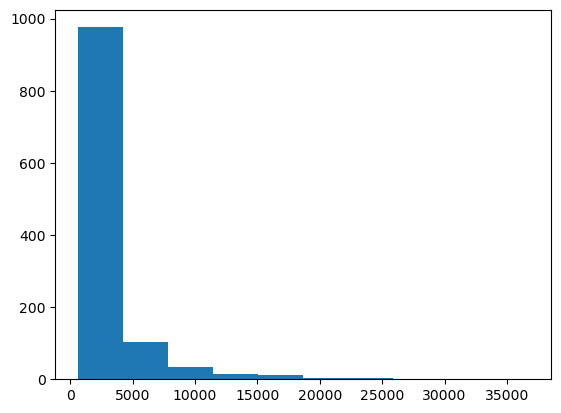

MANUALLY ADDING BACKGROUND THIS MUST BE CHANGED BACK XXXX
Subtracted a BG of 1467.994604557025
WGT shape (625,)
Constructing PSFs...
3 n_grid
Building BG Image 1 of 1
This is for while cwork is down
Setting agreed upon wcs
Constructing grid locally centered
x in grid [-3.  -1.4  0.2  1.8  3.4]
y in grid [-3.  -1.4  0.2  1.8  3.4]
Constructing psf background locally with precise version...
Background
Design
Product
(625, 27)
Solving
Solved


/tmp/ipykernel_1294512/1909207071.py:443: RuntimeWarning: divide by zero encountered in log10
  self.mag = -2.5 * np.log10(self.flux) + self.common_zpt


In [5]:
#%matplotlib widget
#ID = 20172782

#ID = 90000055
#ID = 70000282
#ID = 20073665

#ID = 50129236
ID = 20055347

#ID = 30597443  

#ID = 20170506
snpath = '/global/cfs/cdirs/lsst/www/DESC_TD_PUBLIC/Roman+DESC/PQ+HDF5_ROMAN+LSST_LARGE'
roman_path = '/global/cfs/cdirs/lsst/shared/external/roman-desc-sims/Roman_data'
pqfile = find_parq(ID, snpath)
print(pqfile)
band = 'F184'
ra, dec, p, s, start, end, peak = SNID_to_loc(ID, pqfile, date = True, band = band, snpath = snpath, roman_path = roman_path)
print(ra,dec)
test = MultiDetection(ra, dec, p, s, band, start, end, peak, snid = ID)
nbg = 3

test.runPhotometry(background = True, err = False, n_grid = nbg, maxbg = 0, maxdet = -1, roman_path = roman_path, \
                  pointing_list = None, SCA_list = None, bare_bones = False, precise = True)


1259.2105981863642
0
27.90469069909979
-0.9970155996624044
28.901706298762193


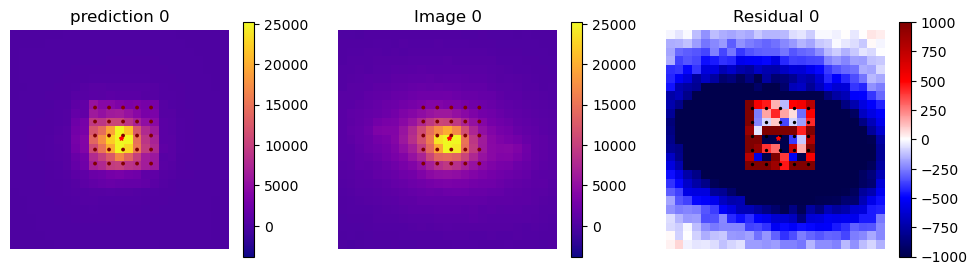

In [6]:

from image_tools import clippedMean
plt.figure(figsize=(12, 14*test.ntot))
yplots = 8
xplots = test.ntot//2 + 1




bgtol = 10000
im = test.image[0*25*25 : (0+1) * 25 * 25]
sig = np.sqrt(clippedMean(im, 4)[1])
print(sig)



for i in range(test.ntot):
    print(i)
    plt.subplot(4*test.ntot, 3, 3*i+1,projection=test.wcs_list[i])

    xx, yy = test.wcs_list[i].world_to_pixel(SkyCoord(ra = test.ra_grid*u.degree, dec = test.dec_grid*u.degree))

    snx, sny = test.wcs_list[i].world_to_pixel(SkyCoord(ra = test.ra*u.degree, dec = test.dec*u.degree))
    xx += 0.5
    yy += 0.5
    snx += 0.5
    sny += 0.5
    plt.scatter(xx,yy, c = test.X[:np.size(test.ra_grid)], s = 3, cmap = 'seismic', vmin = -bgtol, vmax = bgtol)
    plt.scatter(snx, sny, c = 'r', s = 8, marker = '*')

    this = test.pred[i*25*25 : (i+1) *25 * 25]
    im = test.image[i*25*25 : (i+1) * 25 * 25]
    
    plt.imshow(this.reshape((25,25)), cmap='plasma', vmin = -3*sig, vmax = 20*sig, origin = 'lower',\
        extent = [0, 25, 0 ,25], aspect = 'equal')
    plt.axis('off')
    plt.title(f'prediction {i}')
    plt.colorbar()
    print(this[0])


    ############################
    
    plt.subplot(4*test.ntot, 3, 3*i+2,projection=test.wcs_list[i])
    #plt.subplot(4*test.ntot, 3, 3*i+2)
    this2 = test.image[i*25*25 : (i+1) *25 * 25]
    plt.scatter(xx,yy, c = test.X[:np.size(test.ra_grid)], s = 3, cmap = 'seismic', vmax = bgtol, vmin = -bgtol)
    plt.scatter(snx, sny, c = 'r', s = 8, marker = '*')
    plt.imshow(this2.reshape((25,25)), cmap='plasma',vmin = -3*sig, vmax = 20*sig, origin = 'lower',\
        extent = [0, 25, 0 ,25], aspect = 'equal')
    plt.colorbar()
    plt.axis('off')
    plt.title(f'Image {i}')
    print(this2[0])

    ############################

    plt.subplot(4*test.ntot, 3, 3*i+3,projection=test.wcs_list[i])
    plt.scatter(xx,yy,  s = 2, color = 'k')
    #plt.subplot(4*test.ntot, 3, 3*i+3)
    this = test.res[i*25*25 : (i+1) *25 * 25]
    im = test.image[i*25*25 : (i+1) * 25 * 25]
    
    plt.imshow(this.reshape(25,25),cmap='seismic', origin = 'lower',\
        extent = [0, 25, 0 ,25], aspect = 'equal', vmin = -1000, vmax = 1000)
    plt.colorbar()

    plt.scatter(snx, sny, c = 'r', s = 8, marker = '*')
    plt.axis('off')
    plt.title(f'Residual {i}')
    print(this[0])

    
plt.show()

true flux
---------


ValueError: 'x' and 'y' must have the same size

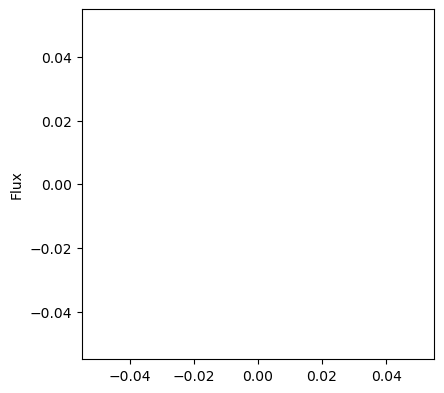

In [7]:
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
dates = test.exposures[np.where(test.exposures['DETECTED'])]['date']

plt.ylabel('Flux')

truths = test.exposures[np.where(test.exposures['DETECTED'])]['true flux']

print(truths)
plt.scatter(dates,truths, label = 'True LC', s = 10)
plt.errorbar(dates, test.flux , fmt = 'o', label = 'Measured LC', color = 'k', ms = 3)
print(test.flux)
#plt.ylim(np.nanmax(test.mag) + 1, np.nanmin(test.mag) - 1)
plt.legend()

plt.subplot(2,2,3)
plt.scatter(dates,test.flux - truths , label = 'residuals', s = 10)
plt.plot([np.min(dates), np.max(dates)], [0,0], color = 'k', ls = '--')
plt.ylabel('Flux Residual')
plt.xlabel('MJD')


plt.subplot(2,2,2)
dates = test.exposures[np.where(test.exposures['DETECTED'])]['date']

plt.ylabel('Magnitude, Uncalibrated')


#test_mags = -2.5 * np.log10(test.flux) + 14.62199

truths = test.exposures[np.where(test.exposures['DETECTED'])]['true mag']
plt.scatter(dates,truths, label = 'True LC', s = 3, marker = 'o')
plt.errorbar(dates, test.mag , fmt = 'o', label = 'Measured LC', color = 'k', ms = 3)
#plt.errorbar(dates, test_mags , fmt = 'o', label = 'Measured LC', color = 'g', ms = 3)
plt.ylim(np.nanmax(test.mag) + 1, np.nanmin(test.mag) - 1)
plt.legend()

nbg = test.ntot - test.ndet
for i in range(test.ndet):
    plt.text(dates[i], test.mag[i]+0.1, f'{nbg + i}', fontsize = 8)

plt.subplot(2,2,4)
plt.xlabel('MJD')
plt.ylabel('Magnitude Residual, Recovered - True')
plt.scatter(dates,test.mag - truths, color = 'k', s = 10)
#plt.scatter(dates,truths - test_mags, color = 'g', s = 10)
plt.plot([np.min(dates), np.max(dates)], [0,0], 'k--', label = 'Zeroline')
plt.plot([np.min(dates), np.max(dates)], [0.01,0.01], 'r--', label = '+/- 0.01 mag')
plt.plot([np.min(dates), np.max(dates)], [-0.01,-0.01], 'r--')
for i in range(test.ndet):
    plt.text(dates[i],  test.mag[i]+0.003 - truths[i], f'{nbg + i}', fontsize = 8)
    
    
lower = max(np.nanmax(test.mag - truths) * 1.1, 0.03)
upper = min(np.nanmin(test.mag - truths) * 1.1, -0.03)
plt.ylim(lower,upper)
plt.legend()


  
plt.show()


    



412.16333850679075
132.69412472709428
-----
860.9271101948639
1633.877219508121
-----
949.7416740902531
-20.414851703453678
-----
1079.914665154758
1116.0029499729885
-----
870.5878218000871
696.264984987231
-----
607.5351714693265
-752.8336832416858
-----
801.9487093251228
1752.989201201557
-----
1745.0079666467245
-859.9073403277935
-----
991.6439281634011
3214.821213619868
-----
420.218571322137
216.5602979020432
-----
405.48973184801525
813.6432470312311
-----
996.3063802920869
2694.237645579121
-----
1466.3256468759828
-542.4969295066262
-----
503.73853957774554
-464.53027953541687
-----
997.8752008684846
-884.1345222613572
-----
652.9396831921042
-2189.168655105426
-----
322.73029367606523
-1535.8206453479306
-----
815.7879987617962
-2622.4809891044465
-----
497.2105261146162
2204.233485097703
-----
1655.0872867606402
1007.8624424369582
-----


Text(0, 0.5, 'Magnitude Residual, recovered - true')

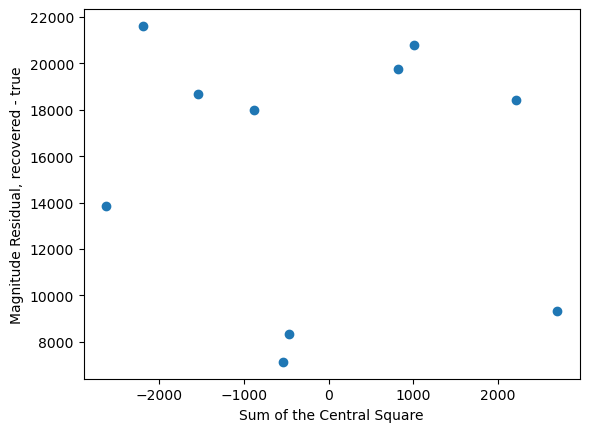

In [38]:
totalsums = []
centersums = []

for i in range(test.ntot):
    this = test.res[i*25*25 : (i+1) *25 * 25]
    print(np.sum(this))
    totalsums.append(np.sum(this))
    this = test.res[i*25*25 : (i+1) *25 * 25].reshape(25,25)[9:16,9:16]
    centersums.append(np.sum(this))
    print(np.sum(this))
    print('-----')
truths = test.exposures[np.where(test.exposures['DETECTED'])]['true mag']
#truths = test.exposures[np.where(test.exposures['DETECTED'])]['true flux']
plt.scatter(centersums[-test.ndet:], test.flux - truths)
plt.xlabel('Sum of the Central Square')
plt.ylabel('Magnitude Residual, recovered - true')


In [35]:
np.save(str(test.snid)+'center_sums.npy', centersums[-test.ndet:])
np.save(str(test.snid)+'mag_residuals.npy', centersums[-test.ndet:])

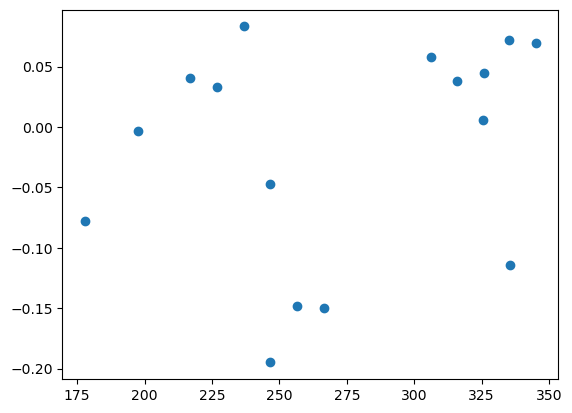

In [149]:
truth = 'simple_model'
band = 'F184'
orientations = []
[np.where(test.exposures['true mag'] <= 7)]
for i in range(len(test.exposures[np.where(test.exposures['true mag'] <= 7)]['Pointing'])):
    Pointing = test.exposures[np.where(test.exposures['true mag'] <= 7)]['Pointing'][i]
    SCA = test.exposures[np.where(test.exposures['true mag'] <= 7)]['SCA'][i]
    image = fits.open(roman_path + f'/RomanTDS/images/{truth}/{band}/{Pointing}/Roman_TDS_{truth}_{band}_{Pointing}_{SCA}.fits.gz')[1]
    orientations.append(image.header['ORIENTAT'])


plt.scatter(orientations, test.mag[truths <= 7] - truths[truths<=7])

In [31]:
'''
chis = []
for i in range(test.ntot):
    this = test.res[i*25*25 : (i+1) *25 * 25]
    im = test.image[i*25*25 : (i+1) * 25 * 25]
    if i > test.ntot - test.ndet - 1:
        chis.append(np.sum(this))

residuals = test.exposures[np.where(test.exposures['DETECTED'])]['true mag'] - test.mag[0]
print(np.size(chis))
print(np.size(residuals))
plt.scatter(chis, residuals)
plt.xlabel('residual sum')
plt.ylabel('Error in flux')
plt.show()
'''


"\nchis = []\nfor i in range(test.ntot):\n    this = test.res[i*25*25 : (i+1) *25 * 25]\n    im = test.image[i*25*25 : (i+1) * 25 * 25]\n    if i > test.ntot - test.ndet - 1:\n        chis.append(np.sum(this))\n\nresiduals = test.exposures[np.where(test.exposures['DETECTED'])]['true mag'] - test.mag[0]\nprint(np.size(chis))\nprint(np.size(residuals))\nplt.scatter(chis, residuals)\nplt.xlabel('residual sum')\nplt.ylabel('Error in flux')\nplt.show()\n"

In [37]:
'''
chis = []
for i in range(test.ntot):
    this = test.res[i*25*25 : (i+1) *25 * 25]
    im = test.image[i*25*25 : (i+1) * 25 * 25]
    if i > test.ntot - test.ndet - 1:
        chis.append(np.sum(this))

residuals = test.exposures[np.where(test.exposures['DETECTED'])]['true mag'] - test.mag[0]
print(np.size(chis))
print(np.size(residuals))
plt.scatter(chis, residuals)
plt.xlabel('residual sum')
plt.ylabel('Error in flux')
plt.show()
'''

"\nchis = []\nfor i in range(test.ntot):\n    this = test.res[i*25*25 : (i+1) *25 * 25]\n    im = test.image[i*25*25 : (i+1) * 25 * 25]\n    if i > test.ntot - test.ndet - 1:\n        chis.append(np.sum(this))\n\nresiduals = test.exposures[np.where(test.exposures['DETECTED'])]['true mag'] - test.mag[0]\nprint(np.size(chis))\nprint(np.size(residuals))\nplt.scatter(chis, residuals)\nplt.xlabel('residual sum')\nplt.ylabel('Error in flux')\nplt.show()\n"

In [ ]:
'''
chis = []
means = []

det_array = None
bg_array = None
det_means = []
bg_means = []
for i in range(test.ntot):
    this = test.res[i*25*25 : (i+1) *25 * 25]
    im = test.image[i*25*25 : (i+1) * 25 * 25]
    bins = np.linspace(-400, 400, 100)
    #concatenate this onto the list
    if i > test.ntot - test.ndet:
        det_means.append(np.mean(this))
        if det_array is None:
            det_array = this
        else:
            det_array = np.hstack((det_array, this))
    else:
        bg_means.append(np.mean(this))
        if bg_array is None:
            bg_array = this
        else:
            bg_array = np.hstack((bg_array, this))


#plt.hist(bg_array, bins = 200)
#plt.hist(det_array, bins = 200)
plt.hist(bg_means, label = 'background residual sums', histtype = 'step', lw = 5, bins = 10)
plt.hist(det_means, label = 'detection residual sums', histtype = 'step', lw = 5, bins = 10)
print(np.mean(bg_array), np.std(bg_array)/np.sqrt(np.size(bg_array)))
print(np.mean(det_array), np.std(det_array)/np.sqrt(np.size(det_array)))
plt.title('Whole image residual sums')
plt.legend()
plt.show()
'''

In [ ]:
'''
chis = []
means = []

det_array = None
bg_array = None
det_means = []
bg_means = []
print(test.ntot)
for i in range(test.ntot):
    this = test.res[i*25*25 : (i+1) *25 * 25]
    this = this.reshape((25,25))
    this = this[12 - 2: 12 + 3, 12 - 2: 12 + 3]
    #plt.subplot(7,8,i+1)
    #plt.imshow(this, cmap = 'plasma')

    bins = np.linspace(-400, 400, 100)
    #concatenate this onto the list
    if i > test.ntot - test.ndet:
        det_means.append(np.mean(this))
        '''

        '''
    else:
        bg_means.append(np.mean(this))
        '''

        '''
plt.title('Central 5x5 pixel residual sums')
bins = np .linspace(0, 13, 20)
plt.hist(bg_means, label = 'background residual sums', histtype = 'step', lw = 5, bins = bins)
plt.hist(det_means, label = 'detection residual sums', histtype = 'step', lw = 5, bins = bins)
#print(np.mean(bg_array), np.std(bg_array)/np.sqrt(np.size(bg_array)))
#print(np.mean(det_array), np.std(det_array)/np.sqrt(np.size(det_array)))
plt.legend()
plt.show()
'''

In [ ]:
'''
chis = []
for i in range(test.ntot):
    this = test.res[i*25*25 : (i+1) *25 * 25]
    this = this.reshape((25,25))
    this = this[12 - 2: 12 + 3, 12 - 2: 12 + 3]
    if i > test.ntot - test.ndet - 1:
        chis.append(np.mean(this))

residuals = test.exposures[np.where(test.exposures['DETECTED'])]['true mag'] - test.mag[0]
print(np.size(chis))
print(np.size(residuals))
plt.scatter(chis, residuals)
plt.xlabel('residual sum')
plt.ylabel('Error in Magnitudes')
plt.show()
'''

In [ ]:
'''
df = open_parq(10430)
reals = df.loc[(df.peak_mjd < 62800.0)]
reals = reals.loc[(df.peak_mjd > 62400.0)]
reals = reals.loc[reals.host_mag_F < 999]
#reals = reals.loc[reals.ra > 6.487]
reals = reals.loc[reals.ra > 7]
#reals = reals.loc[reals.ra < 12.51]
reals = reals.loc[reals.ra < 8]
#reals = reals.loc[reals.dec > -46.877]
reals = reals.loc[reals.dec > -45]
#reals = reals.loc[reals.dec < -41.124]
reals = reals.loc[reals.dec < -44]


#add column to reals
reals['outshine'] = reals.peak_mag_F / reals.host_mag_F
#sort by outshine
reals = reals
reals = reals.sort_values('peak_mag_F')
print(list(reals[:20].id))
'''

In [26]:
#Code to loop thru many SNe.
snpath = '/global/cfs/cdirs/lsst/www/DESC_TD_PUBLIC/Roman+DESC/PQ+HDF5_ROMAN+LSST_LARGE'
roman_path = '/global/cfs/cdirs/lsst/shared/external/roman-desc-sims/Roman_data'

df = open_parq(10430, path = snpath)
reals = df.loc[(df.peak_mjd < 62800.0)]
reals = reals.loc[(df.peak_mjd > 62400.0)]
reals = reals.loc[reals.host_mag_F < 999]
#reals = reals.loc[reals.ra > 6.487]
reals = reals.loc[reals.ra > 7]
#reals = reals.loc[reals.ra < 12.51]
reals = reals.loc[reals.ra < 8]
#reals = reals.loc[reals.dec > -46.877]
reals = reals.loc[reals.dec > -45]
#reals = reals.loc[reals.dec < -41.124]
reals = reals.loc[reals.dec < -44]


#add column to reals
reals['outshine'] = reals.peak_mag_F / reals.host_mag_F
#sort by outshine
reals = reals
reals = reals.sort_values('peak_mag_F')

print('looking for these bad boys:')
print(list(reals[:20].id))

filename = 'SN_diagnostic_retest.csv'
import os.path
#30033569 had no detections?
#[70000282, 90000055, 20073665,  20007618, 20039595, 20026864, 20168332, 40004494, 20126937, \
    #20140027, 20185828, 20206831, 40097529, 40035376, 40139832,  20188140, 20129087, 40048286]
for snid in list(reals[1:40].id):
    print(snid, '------------------------------')

    if os.path.isfile(filename):
        df = pd.read_csv(filename, index_col = 0)
        neednew = False
        if snid in df.SNID.values:
            print('Previously Completed')
            continue
        if snid in [50119066]:
            continue
    
    else:
        print('Creating new CSV')
        neednew = True
    #try:
    
    if snid in [50065247]:
        continue
    pqfile = find_parq(snid, path = snpath)
    band = 'F184'
    ra, dec, p, s, start, end, peak = SNID_to_loc(snid, pqfile, date = True, band = band, snpath = snpath, roman_path = roman_path)
    test = MultiDetection(ra, dec, p, s, band, start, end, peak, snid = snid)
    test.runPhotometry(background = False, err = False, n_grid = 30, maxdet = 9, maxbg = 9, roman_path = roman_path)


    savetable = test.exposures.to_pandas()
    det_array = None
    bg_array = None
    det_means = []
    det_means_central = []
    bg_means = []
    bg_means_central = []
    for i in range(test.ntot):
        this = test.res[i*25*25 : (i+1) *25 * 25]
        this = this.reshape((25,25))
        this_central = this[12 - 3: 12 + 4, 12 - 3: 12 + 4]

        bins = np.linspace(-400, 400, 100)
        if i > test.ntot - test.ndet - 1:
            det_means.append(np.mean(this))
            det_means_central.append(np.mean(this_central))
        else:
            bg_means.append(np.sum(this))
            bg_means_central.append(np.sum(this_central))

    det_means = np.array(det_means)
    det_means_central = np.array(det_means_central)
    bg_means = np.array(bg_means)
    bg_means_central = np.array(bg_means_central)

    #Add a new column to the table
    savetable['mag'] = np.nan
    savetable['flux'] = np.nan
    savetable['Residual Mean'] = np.nan
    savetable['Residual Mean Central'] = np.nan
    savetable['SNID'] = test.snid
    savetable['true mag'] = test.exposures['true mag']
    savetable['true flux'] = test.exposures['true flux']


    savetable.loc[savetable['DETECTED'], 'mag'] = test.mag
    savetable.loc[savetable['DETECTED'], 'flux'] = test.flux
    savetable.loc[savetable['DETECTED'],'Residual Mean'] = det_means
    savetable.loc[savetable['DETECTED'], 'Residual Mean Central'] = det_means_central
    savetable.loc[~savetable['DETECTED'], 'Residual Mean'] = bg_means
    savetable.loc[~savetable['DETECTED'], 'Residual Mean Central'] = bg_means_central


    if neednew:
        df = pd.DataFrame(savetable)
        print('Created DF')

        
    else:
        addition_frame = pd.DataFrame(savetable)
        df = pd.concat([df, addition_frame], ignore_index = True)
    df.to_csv(filename)
    break




looking for these bad boys:
[40134404, 50106142, 50129236, 30597443, 50134575, 50022453, 40018655, 20055347, 50027278, 50144007, 40084671, 50070195, 50071618, 40120913, 50065247, 50061540, 60144043, 50118342, 50119066, 50123776]
50106142 ------------------------------
Creating new CSV
looking in band F184
FAE TRUTH: simple_model
657 Potential Candidates
Pointing SCA BAND     zeropoint      ...  true mag  true flux  DETECTED
-------- --- ---- ------------------ ... ---------- ---------- --------
     281  12 F184 14.621993990853726 ...        nan        nan    False
    1052  10 F184 14.621993990679387 ...        nan        nan    False
    1437  14 F184 14.621993990635609 ...        nan        nan    False
    1442  16 F184 14.621993990697574 ...        nan        nan    False
    1818   6 F184 14.621993990699412 ...        nan        nan    False
    1823   4 F184 14.621993990584565 ...        nan        nan    False
    2593  18 F184 14.621993990674847 ...        nan        nan    Fa

3.729177202451094 1.6860582014174046
----

ID: 50106142  mean  0.0008793521170756158 scatter 0.007168920659556362

True [1.86742483 3.73665108 3.70533088 3.67444098 1.8229046  1.78024113
 1.69351939 1.69232648 1.69092595 1.86761027]

Measured [1.86073344 3.7291772  3.72186893 3.67341469 1.82682734 1.77739508
 1.6860582  1.69846864 1.69488603 1.87133956]


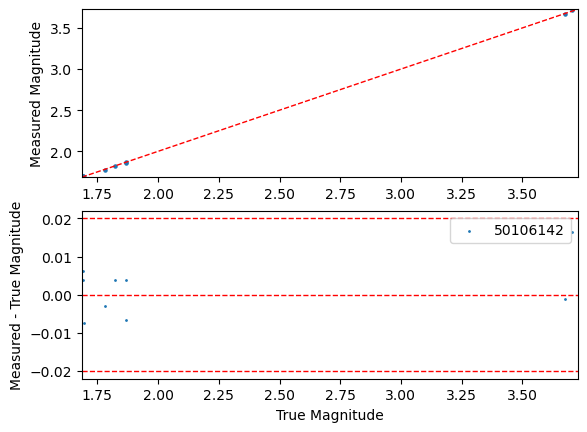

In [27]:


filename = 'SN_diagnostic_retest.csv'
df = pd.read_csv(filename, index_col = 0)


lower = np.nanmin(df['mag'])
upper = np.nanmax(df['mag'].loc[np.where(df['mag'] != np.inf)])
print(upper,lower)
totnum = 1
for snid in np.unique(df['SNID']):
    
    totnum += 1
    #try:

    
    plt.subplot(2,1,1)
    df_sub = df.loc[df.SNID == snid]
    
    plt.scatter(df_sub['true mag'], df_sub['mag'], label = df_sub['SNID'].iloc[0], s = 5)
    plt.xlim(lower,upper)
    plt.ylim(lower,upper)
    plt.ylabel('Measured Magnitude')
    
    #plt.legend()
    plt.subplot(2,1,2)
    
    plt.scatter(df_sub['true mag'] , df_sub['mag']-df_sub['true mag'], label = df_sub['SNID'].iloc[0], s = 1)
    plt.xlim(lower,upper)
    print('----')
    print('')
    print('ID:', snid, ' mean ', np.mean(df_sub['mag'] - df_sub['true mag']), 'scatter', np.std(df_sub['mag'] - df_sub['true mag']))
    print('')
    print('True', df_sub['true mag'].values[10:])
    print('')
    print('Measured', df_sub['mag'].values[10:])
    plt.xlabel('True Magnitude')

    plt.ylabel('Measured - True Magnitude')
    
plt.subplot(2,1,1)
plt.plot([lower, upper], [lower,upper], 'r--', lw = 1)   
plt.subplot(2,1,2)
plt.plot([lower, upper], [0,0], 'r--', lw = 1)
plt.plot([lower, upper], [0.02,0.02], 'r--', lw = 1)
plt.plot([lower, upper], [-0.02,-0.02], 'r--', lw = 1)
plt.legend()



[-0.03840198  0.00973858  0.06228883]
0.2974683544303797
0.4345991561181435


"\n\nfilename = 'SN_diagnostic_bgsub.csv'\ndf = pd.read_csv(filename, index_col = 0)\nresiduals = df['mag'] - df['true mag']\nresiduals = residuals.loc[np.where(residuals != np.inf)]\nplt.hist(residuals, bins = bins, histtype = 'step', density = True)\nprint(np.nanpercentile(residuals, [16,50,84]))\nplt.plot([0.02,0.02],[0,12], 'r--')\nplt.plot([-0.02,-0.02],[0,12], 'r--')\nprint(np.size(residuals[residuals < 0.02])/np.size(residuals))\nprint(np.size(residuals[residuals < 0.1])/np.size(residuals))\n"

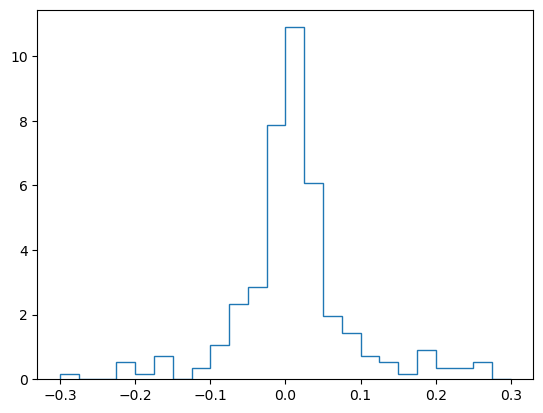

In [7]:

filename = 'SN_diagnostic_barebones.csv'
df = pd.read_csv(filename, index_col = 0)
residuals = df['mag'] - df['true mag']
residuals = residuals.loc[np.where(residuals != np.inf)]
bins = np.linspace(-0.3,0.3,25)
plt.hist(residuals, bins = bins, histtype = 'step', density = True)
print(np.nanpercentile(residuals, [16,50,84]))
print(np.size(residuals[residuals < 0.02])/np.size(residuals))
print(np.size(residuals[residuals < 0.1])/np.size(residuals))
'''

filename = 'SN_diagnostic_bgsub.csv'
df = pd.read_csv(filename, index_col = 0)
residuals = df['mag'] - df['true mag']
residuals = residuals.loc[np.where(residuals != np.inf)]
plt.hist(residuals, bins = bins, histtype = 'step', density = True)
print(np.nanpercentile(residuals, [16,50,84]))
plt.plot([0.02,0.02],[0,12], 'r--')
plt.plot([-0.02,-0.02],[0,12], 'r--')
print(np.size(residuals[residuals < 0.02])/np.size(residuals))
print(np.size(residuals[residuals < 0.1])/np.size(residuals))
'''

[20055347 20170506 30597443 30666595 40018655 40084671 40096456 40120913
 50010393 50022453 50027278 50049302 50061540 50070195 50071618 50093469
 50099064 50106142 50118342 50123776 50129236 50134575 50144007 60144043] 24
[-0.04582836  0.00973858  0.07853037]
0.2893401015228426
0.4289340101522843


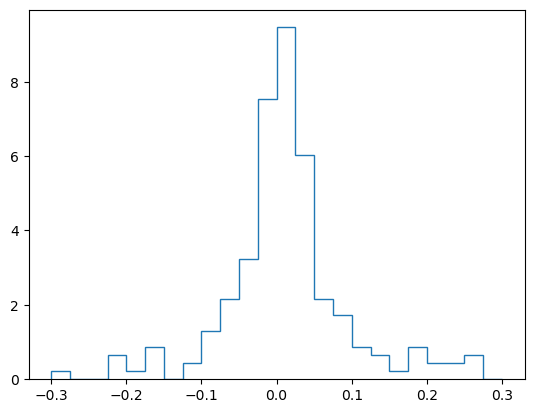

In [28]:

IDs = np.unique(df.SNID)
print(IDs, len(IDs))
IDs = IDs[:20]
new_df = df[df.SNID.isin(IDs)]

residuals = new_df['mag'] - new_df['true mag']

bins = np.linspace(-0.3,0.3,25)
plt.hist(residuals, bins = bins, histtype = 'step', density = True)
print(np.nanpercentile(residuals, [16,50,84]))
print(np.size(residuals[residuals < 0.02])/np.size(residuals))
print(np.size(residuals[residuals < 0.1])/np.size(residuals))


20055347
20170506
30597443
30666595
40018655
40084671
40096456
40120913
50010393
50022453
50027278
50049302
50061540
50070195
50071618
50093469
50099064
50106142
50118342
50123776
50129236
50134575
50144007
60144043


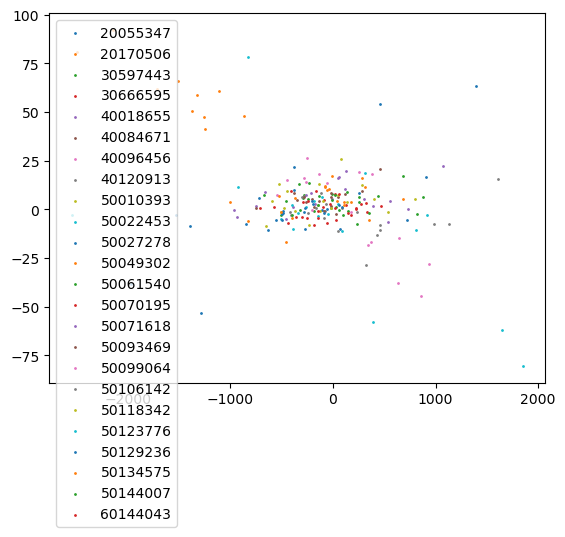

In [8]:

filename = 'SN_diagnostic_barebones.csv'
df = pd.read_csv(filename, index_col = 0)

for snid in np.unique(df['SNID']):
    df_sub = df.loc[df.SNID == snid]
    print(snid)
    plt.scatter(df_sub['flux']-df_sub['true flux'], df_sub['Residual Mean Central'], label = df_sub['SNID'].iloc[0], s = 1)
plt.legend()




In [ ]:
'''
filename = 'SN_diagnostic.csv'
df = pd.read_csv(filename, index_col = 0)
for snid in df['SNID']:
    df_sub = df.loc[df.SNID == snid]
    if np.mean(df_sub['true mag'] < 6):
        plt.scatter(df_sub['Residual Mean Central'].loc[df_sub['DETECTED']],df_sub['mag'].loc[df_sub['DETECTED']] - df_sub['true mag'].loc[df_sub['DETECTED']] , label = df_sub['SNID'].iloc[0], s = 1)
plt.ylabel('Measured - True Magnitude')
plt.xlabel('Central (5x5) Pixel Residual')
plt.plot([-10,20], [0,0], 'r--', lw = 1)
plt.ylim(-0.5,0.5)
'''

In [ ]:
'''
filename = 'SN_diagnostic.csv'
df = pd.read_csv(filename, index_col = 0)
for snid in df['SNID']:
    df_sub = df.loc[df.SNID == snid]
    if np.mean(df_sub['true mag'] < 6):
        plt.scatter(df_sub['Residual Mean'].loc[df_sub['DETECTED']],df_sub['mag'].loc[df_sub['DETECTED']] - df_sub['true mag'].loc[df_sub['DETECTED']] , label = df_sub['SNID'].iloc[0], s = 1)
plt.ylabel('Measured - True Magnitude')
plt.xlabel('Total Pixel Residual')
plt.plot([-10,10], [0,0], 'r--', lw = 1)
#plt.ylim(-2,2)
'''


In [ ]:
'''
plt.subplot(2,1,1)

bins = np.linspace(-20,20,50)
plt.title('Central (5x5) Residual')
plt.hist(df['Residual Mean Central'].loc[df['DETECTED']], bins = bins, histtype = 'step', lw = 1, label = 'Detected', density = True)
plt.hist(df['Residual Mean Central'].loc[~df['DETECTED']], bins = bins, histtype = 'step', lw = 1, label = 'Background', density = True)
plt.legend()
plt.xlim(-20,20)
plt.subplot(2,1,2)
plt.title('Total Residual')
plt.hist(df['Residual Mean'].loc[df['DETECTED']], bins = bins, histtype = 'step', lw = 1, label = 'Detected', density = True)
plt.hist(df['Residual Mean'].loc[~df['DETECTED']], bins = bins, histtype = 'step', lw = 1, label = 'Background', density = True)
plt.legend()
plt.subplots_adjust(hspace = 0.5)
plt.xlim(-20,20)
plt.show()
'''

In [ ]:
'''
def downsample(array,factor):
    """
    Downsample an array by a factor of `factor` in each dimension
    """
    xsize = array.shape[0]
    ysize = array.shape[1]
    output = np.zeros((xsize//factor,ysize//factor))
    assert xsize % factor == 0 and ysize % factor == 0, "Array size must be divisible by factor size is " + str(xsize) + " " + str(ysize) + " factor is " + str(factor)
    for i in range(xsize//factor):
        for j in range(ysize//factor):
            output[i,j] = np.mean(array[i*factor:(i+1)*factor + 1, j*factor:(j+1)*factor + 1])
            print(array[i*factor:(i+1)*factor + 1, j*factor:(j+1)*factor + 1]) #I am unclear if this +1 is correct XXX TODO

    return output
'''
